In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional

from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Setup GPU
In order not to be sure that there is a GPU available for faster computing (x8 to 20 times faster)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        # Uncomment the 3 next lines if you want to limit GPU memory usage
        # tf.config.experimental.set_virtual_device_configuration(
            # gpus[0],
            # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Parameters

In [3]:
# Word2Vec parameters
min_count_word2vec = 30
# NN s general parameters
batch_size = 512
epochs = 25
test_size=0.25
# Embedding parameters
embedding_size = 128
# LSTM s parameters
lstm_size = 256
lstm_dropout = 0.93
lstm_recurrent_dropout = 0.0

# Import cleaned_data CSV

In [4]:
data = pd.read_csv(
    "cleaned_data.csv",
    encoding='latin-1')
data['clean_text'] = data.clean_text.astype(str)

print(data.head())

   polarity                                               text  \
0         0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1         0  is upset that he can't update his Facebook by ...   
2         0  @Kenichan I dived many times for the ball. Man...   
3         0    my whole body feels itchy and like its on fire    
4         0  @nationwideclass no, it's not behaving at all....   

                                          clean_text  
0   awww bummer you shoulda got david carr third day  
1  upset updat facebook text might cri result sch...  
2      dive mani time ball manag save the rest bound  
3                    whole bodi feel itchi like fire  
4                                      behav mad see  


# Load Word2Vec model

In [5]:
tk = Tokenizer(lower=True)
tk.fit_on_texts(data['clean_text'].values)
X_seq = tk.texts_to_sequences(data['clean_text'].values)  # X)
X_pad = pad_sequences(X_seq, maxlen=25, padding='post')  #maxlen must be equal to maxword

# Define functions to create the word2vec weight matrix

In [6]:
def get_weight_matrix(vocab):
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, size_word2vec))

    for w, i in vocab.items():
        # The word_index contains a token for all words of the training data so we need to limit that
        if i < vocab_size:
            try:
                vect = model_Word2Vec.wv.get_vector(w)
                weight_matrix[i] = vect
            # Check if the word from the training data occurs in the GloVe word embeddings
            # Otherwise the vector is kept with only zeros
            except:
                pass
        else:
            break
    return weight_matrix

# Convert text to vector

In [7]:
max_length = max([len(s.split()) for s in data['clean_text']])
# fit the tokenizer on the documents
tk = Tokenizer(lower=True)
tk.fit_on_texts(data['clean_text'].values)

# define vocabulary size (largest integer value)
vocab_size = len(tk.word_index) + 1

# transform each text into a list of tokens
X_seq = tk.texts_to_sequences(data['clean_text'].values)
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Split test/train data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, data['polarity'].values, test_size=test_size, random_state=1, shuffle=True)

# split train and validation set
X_train1 = X_train[batch_size:]
y_train1 = y_train[batch_size:]
X_valid = X_train[:batch_size]
y_valid = y_train[:batch_size]

# Model description

In [9]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
model.add(Bidirectional(LSTM(lstm_size, dropout=lstm_dropout, recurrent_dropout=lstm_recurrent_dropout, return_sequences=True)))
model.add(Bidirectional(LSTM(lstm_size, dropout=lstm_dropout, recurrent_dropout=lstm_recurrent_dropout)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training

In [10]:
history = model.fit(X_train1, y_train1, shuffle=True, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=epochs)

Epoch 1/25
2343/2343 [==============================] - 655s 280ms/step - loss: 0.5101 - accuracy: 0.7483 - val_loss: 0.4314 - val_accuracy: 0.7910
Epoch 2/25
2343/2343 [==============================] - 652s 278ms/step - loss: 0.4770 - accuracy: 0.7717 - val_loss: 0.4230 - val_accuracy: 0.7988
Epoch 3/25
2343/2343 [==============================] - 651s 278ms/step - loss: 0.4682 - accuracy: 0.7770 - val_loss: 0.4225 - val_accuracy: 0.7988
Epoch 4/25
2343/2343 [==============================] - 650s 277ms/step - loss: 0.4619 - accuracy: 0.7812 - val_loss: 0.4188 - val_accuracy: 0.7988
Epoch 5/25
2343/2343 [==============================] - 651s 278ms/step - loss: 0.4573 - accuracy: 0.7836 - val_loss: 0.4190 - val_accuracy: 0.8066
Epoch 6/25
2343/2343 [==============================] - 650s 278ms/step - loss: 0.4540 - accuracy: 0.7860 - val_loss: 0.4197 - val_accuracy: 0.7988
Epoch 7/25
2343/2343 [==============================] - 648s 277ms/step - loss: 0.4499 - accuracy: 0.7883 - val_

# Evaluate the model performance

Test accuracy :  0.7769324779510498


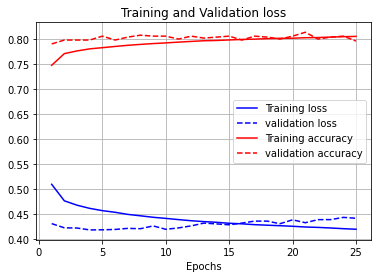

In [11]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy : ", scores[1])


loss = history.history['loss']
loss_val = history.history['val_loss']
accuracy = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, loss_val, 'b--', label='validation loss')
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'r--', label='validation accuracy')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Save the plot with few caracteristics in the name
scores[1] = str(scores[1]).replace(".",",")
lstm_dropout = str(lstm_dropout).replace(".",",")
print(scores[1])
plt.savefig('OHE 2BidiLSTM score {} drop {} sizeLSTM {}.png'.format(scores[1], lstm_dropout, lstm_size))

0,7769324779510498


<Figure size 432x288 with 0 Axes>